In [60]:
import pandas as pd
import numpy as np
from mapping import Mapping
import seaborn as sns
fig_prefix = "../figures/2018-08-22_jw-markov_size_test_"
data_prefix = "../data/2018-08-22_jw-markov_size_test_"

In [4]:
FLOAT_ERROR_TOLERANCE = 0.00000000001 #See IEEE 754 for why a floating point is never perfect
df_strings = ['../data/08-04-2018_23-37-09.csv']
frames = []
for csv in df_strings:
    temp = pd.read_csv(csv,index_col=False )
    frames.append(temp)
df = pd.concat(frames,ignore_index=True)
print(df.shape)
df = df.drop(columns=['Time'])
df = df.dropna() #Get rid of any rows with NA in it.
df = df.apply(pd.to_numeric)
df.head(10)

(56740222, 8)


,ID,X,Y,Yaw,ResetID,checkCorrectness,NumberOfWalls
0,0,0.000000,0.0000,0.000000,1,0,0.0
1,0,-0.466000,-0.2796,0.292237,2,1,0.0
2,0,-0.465999,-0.2796,0.292237,2,1,0.0
3,0,-0.465999,-0.2796,0.292237,2,1,0.0
4,0,-0.465999,-0.2796,0.292237,2,1,0.0
5,0,-0.465999,-0.2796,0.292237,2,1,0.0
6,0,-0.465998,-0.2796,0.292237,2,1,0.0
7,0,-0.465998,-0.2796,0.292237,2,1,0.0
8,0,-0.465998,-0.2796,0.292237,2,1,0.0
9,0,-0.465998,-0.2796,0.292237,2,1,0.0


In [5]:
SAMPLING_RATE = 250 #Keep 1 row for every SAMPLING_RATE
df_sampled = df.iloc[::SAMPLING_RATE,:]
print("Size of new DF is {}".format(df_sampled.shape))
df_sampled.head(10)

Size of new DF is (226961, 7)


,ID,X,Y,Yaw,ResetID,checkCorrectness,NumberOfWalls
0,0,0.000000,0.000000,0.000000,1,0,0.0
250,0,-0.482503,-0.306513,0.311928,2,1,0.0
500,0,-0.481564,-0.273259,0.297979,2,1,0.0
750,0,-0.444129,-0.303773,0.261811,2,1,0.0
1000,0,-0.373807,-0.350501,0.262825,2,1,0.0
1250,0,-0.290904,-0.402638,0.268619,2,1,0.0
1500,0,-0.211749,-0.479484,0.257386,2,1,0.0
1750,0,-0.164203,-0.493754,-0.095464,2,1,0.0
2000,0,-0.112374,-0.441557,-0.535227,2,1,0.0
2250,0,-0.137613,-0.347291,-0.874043,2,1,0.0


In [6]:
#Clean up the data
df_clean = df_sampled.copy()

#Replace the row indexes with a range from 0..n because originally on import of multiple data files it will start from 1 for each file
df_clean.index = range(df_clean.shape[0])
#When the gazebo run it may collect some data of the robots when they aren't moving for the first few 50 or so samples.
#TODO
df_clean.head()

,ID,X,Y,Yaw,ResetID,checkCorrectness,NumberOfWalls
0,0,0.000000,0.000000,0.000000,1,0,0.0
1,0,-0.482503,-0.306513,0.311928,2,1,0.0
2,0,-0.481564,-0.273259,0.297979,2,1,0.0
3,0,-0.444129,-0.303773,0.261811,2,1,0.0
4,0,-0.373807,-0.350501,0.262825,2,1,0.0


In [7]:
#Clean up the data

#Shift Yaw to go from 0 to 2pi, so just add PI since it currently goes for -pi to pi

df_clean['Yaw'] += np.pi
if(df_clean['Yaw'].max() > 2 * np.pi or df_clean['Yaw'].min() < 0):
    print("[ERROR] Cleaning Yaw failed. Make sure range is from 0 and 2 * pi")
    print("Yaw = ({} - {})".format(df_clean['Yaw'].min(), df_clean['Yaw'].max()))


df_clean.head()

,ID,X,Y,Yaw,ResetID,checkCorrectness,NumberOfWalls
0,0,0.000000,0.000000,3.141593,1,0,0.0
1,0,-0.482503,-0.306513,3.453521,2,1,0.0
2,0,-0.481564,-0.273259,3.439572,2,1,0.0
3,0,-0.444129,-0.303773,3.403404,2,1,0.0
4,0,-0.373807,-0.350501,3.404418,2,1,0.0


In [8]:
#Clean up the data

#Shift X and Y over so that way it could be made easier to use. Currently the world reference is at the center of the "play area"
LENGTH_OF_BOX = 1.127 #This can be obtained from the .sdf file of the weazelball enclosure in gazebo


df_clean['X'] += LENGTH_OF_BOX / 2
df_clean['Y'] += LENGTH_OF_BOX / 2
if (df_clean['X'].max() > LENGTH_OF_BOX or df_clean['Y'].max() > LENGTH_OF_BOX or df_clean['X'].min() < 0 or df_clean['Y'].min() < 0):
    print("[ERROR] Cleaning X/Y failed, Make sure the points are between 0 and LENGTH_OF_BOX")
    print("Y = ({} - {}) X = ({} to {})".format(df_clean['Y'].min(), df_clean['Y'].max(), df_clean['X'].min(), df_clean['X'].max()))
df_clean.head()


,ID,X,Y,Yaw,ResetID,checkCorrectness,NumberOfWalls
0,0,0.563500,0.563500,3.141593,1,0,0.0
1,0,0.080997,0.256987,3.453521,2,1,0.0
2,0,0.081936,0.290241,3.439572,2,1,0.0
3,0,0.119371,0.259727,3.403404,2,1,0.0
4,0,0.189693,0.212999,3.404418,2,1,0.0


In [9]:
#Discretize the data
NUMBER_OF_SQUARES = 100 #This should be a square number to create equal sized squares.
RESOLUTION_OF_S1 = 0.1 #This is used to discretize the yaw angle over 0 - 2*pi

df_discretized = df_clean.copy()
    
mappingBoxConstant = (NUMBER_OF_SQUARES ** (1/2.0)) / (LENGTH_OF_BOX)
for index, row in df_clean.iterrows():
    df_discretized.at[index, 'X'] = int(row['X'] * mappingBoxConstant)
    df_discretized.at[index, 'Y'] = int(row['Y'] * mappingBoxConstant)
    df_discretized.at[index, 'Yaw'] = int(row['Yaw'] / RESOLUTION_OF_S1) * RESOLUTION_OF_S1
        
df_discretized.describe()

,ID,X,Y,Yaw,ResetID,checkCorrectness,NumberOfWalls
count,226961.0,226961.000000,226961.000000,226961.000000,226961.000000,226961.000000,226961.0
mean,0.0,4.471028,4.510374,3.089414,48.706143,0.999996,0.0
std,0.0,2.954671,2.972139,1.809770,27.254503,0.002099,0.0
min,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.0
25%,0.0,2.000000,2.000000,1.500000,25.000000,1.000000,0.0
50%,0.0,4.000000,5.000000,3.100000,49.000000,1.000000,0.0
75%,0.0,7.000000,7.000000,4.600000,72.000000,1.000000,0.0
max,0.0,9.000000,9.000000,6.200000,96.000000,1.000000,0.0


In [20]:


#The formula for mapping a 3D array to 1D is
#(z * xMax * yMax) + (y * xMax) + x;
#https://stackoverflow.com/questions/7367770/how-to-flatten-or-index-3d-array-in-1d-array
X_MAX = NUMBER_OF_SQUARES ** (1/2.0)
Y_MAX = NUMBER_OF_SQUARES ** (1/2.0)
YAW_MAX = (2 * np.pi) / RESOLUTION_OF_S1
mapping = Mapping(X_MAX, Y_MAX, YAW_MAX)#Fill in the logical areas that the system can reach (For now I am assuming it can go up/down 2 yaw states or the surronding (x,y) blocks)
d = {} #d is used to hold all the transitions and keep a counter of how often each occur

TRANSLATION_MATRIX_INITIAL_VALUE = 0
#Create the matrix representing the Markov Chain
#I am assuming we are discretizing the space into equal sized boxes
#The transition matrix A is of size 
#( # of states of X * # of states of Y * # of states of Yaw)
#( # of states of X and Y = mappingBoxConstant * LENGTH_OF_BOX )
#( # of states of Yaw = int(2*pi / RESOLUTION_OF_S1)+1)
number_of_x_states = mappingBoxConstant * LENGTH_OF_BOX
number_of_y_states = mappingBoxConstant * LENGTH_OF_BOX
number_of_s1_states = int(2*np.pi / RESOLUTION_OF_S1) + 1
n = int(number_of_x_states * number_of_y_states * number_of_s1_states) #n is the size of the transition matrix
n

6300

In [21]:
from scipy import sparse
from sklearn.preprocessing import normalize
#scipy_start_time = time.time()

In [47]:
#HUERISTIC: Add a +1 to any logical possible state the structure would likely end up in.
#This lowers the amount of artifiical data in the matrix (most of which isnt needed)
l_changes = []
#Each sample in the df after being sampled represents 1/4 of a second. 
minutes_to_run = []
for i in range(5,1000,5):
    minutes_to_run.append(i)
last_dok_sparse_matrix = {}
for minutes in minutes_to_run:
    d = {}
    size_of_new_df = minutes * 4 * 60
    df_minutes_test = df_discretized.iloc[:size_of_new_df,:]
    for index in range(n):
        if(TRANSLATION_MATRIX_INITIAL_VALUE == 0):
            break
        (x,y,yaw) = mapping.map1Dto3D(index)
        #Generate all possible (x,y,yaw) permutations
        #I assume we can only move with 1 around (x,y) including diagnols and +- 2 yaw states
        VARIATION_OF_X = 1
        VARIATION_OF_Y = 1
        VARIATION_OF_YAW = 1
        possible_spots = []
        for x_p in range(-VARIATION_OF_X,VARIATION_OF_X+1):
            for y_p in range(-VARIATION_OF_Y,VARIATION_OF_Y+1):
                for yaw_p in range(-VARIATION_OF_YAW,VARIATION_OF_YAW+1):
                    if(mapping.checkValid3DMap(x+x_p, y+y_p, yaw+yaw_p)):
                        possible_spots.append( (x+x_p, y+y_p, yaw+yaw_p) )
        for pose in possible_spots:
            key = (x,y,yaw, pose[0],pose[1],pose[2])
            if key in d:
                d[key] += 1
            else:
                d[key] = 1
    #Our keys to the dictionary will look like (x_t, y_t, yaw_t, x_t+1, y_t+1, yaw_t+1)
    #Go through all but last row since t+1 isnt defined there...
    skipCount = 0
    try:
        for index, row in df_minutes_test.iterrows():
            if(index == df_minutes_test.index[-1]):
                break
            if(df_minutes_test.at[index, 'ResetID'] != df_minutes_test.at[index + 1, 'ResetID']):
                skipCount += 1
                continue
            #Need to round here because Yaw data has floating point error
            key = (df_minutes_test.at[index, 'X'], df_minutes_test.at[index, 'Y'], round(df_minutes_test.at[index, 'Yaw'], 6),df_discretized.at[index+1, 'X'], df_discretized.at[index+1, 'Y'], round(df_discretized.at[index+1, 'Yaw'], 6) )

            if key in d:
                d[key] += 1
            else:
                d[key] = 1
    except Exception as e:
        print e

    print "[DEBUG] Skipped {} events".format(skipCount)
    sparse_matrix = sparse.dok_matrix((n, n), dtype=np.float32)
    
    for key, value in d.iteritems():
        element_t = mapping.map3Dto1D(key[0], key[1], key[2])
        element_t_plus_1 = mapping.map3Dto1D(key[3], key[4], key[5])
        sparse_matrix[element_t, element_t_plus_1] = value + sparse_matrix[element_t, element_t_plus_1]

    
    #### Make the rows have a magnitude of 1
    sparse_matrix_normalized = normalize(sparse_matrix, norm='l1', axis=1)
    sparse_matrix_normalized = sparse_matrix_normalized.todok()
    #get difference between new matrix and old matrix]
    keys = list(last_dok_sparse_matrix.keys()) + list(sparse_matrix_normalized.keys())
    difference = 0
    for key in keys:
        old_d_val = new_d_val = 0
        if key in last_dok_sparse_matrix:
            old_d_val = last_dok_sparse_matrix.get(key)
        else:
            old_d_val = 0
        if key in sparse_matrix_normalized:
            new_d_val = sparse_matrix_normalized.get(key)
        else:
            new_d_val = 0

        difference += abs(float(new_d_val) - float(old_d_val))
        
    l_changes.append( (minutes, difference) )
    last_dok_sparse_matrix = sparse_matrix_normalized
    

[DEBUG] Skipped 1 events
[DEBUG] Skipped 1 events
[DEBUG] Skipped 2 events
[DEBUG] Skipped 2 events
[DEBUG] Skipped 3 events
[DEBUG] Skipped 3 events
[DEBUG] Skipped 4 events
[DEBUG] Skipped 4 events
[DEBUG] Skipped 5 events
[DEBUG] Skipped 5 events
[DEBUG] Skipped 6 events
[DEBUG] Skipped 6 events
[DEBUG] Skipped 7 events
[DEBUG] Skipped 7 events
[DEBUG] Skipped 8 events
[DEBUG] Skipped 8 events
[DEBUG] Skipped 9 events
[DEBUG] Skipped 9 events
[DEBUG] Skipped 10 events
[DEBUG] Skipped 10 events
[DEBUG] Skipped 11 events
[DEBUG] Skipped 11 events
[DEBUG] Skipped 12 events
[DEBUG] Skipped 12 events
[DEBUG] Skipped 13 events
[DEBUG] Skipped 13 events
[DEBUG] Skipped 14 events
[DEBUG] Skipped 14 events
[DEBUG] Skipped 15 events
[DEBUG] Skipped 15 events
[DEBUG] Skipped 16 events
[DEBUG] Skipped 16 events
[DEBUG] Skipped 17 events
[DEBUG] Skipped 17 events
[DEBUG] Skipped 18 events
[DEBUG] Skipped 18 events
[DEBUG] Skipped 19 events
[DEBUG] Skipped 19 events
[DEBUG] Skipped 20 events
[DEB

In [65]:
df = pd.DataFrame(l_changes, columns=['minutes_sampled', 'difference'])
df['Average_row_change'] = df['difference'] / 6500.0
df

,minutes_sampled,difference,Average_row_change
0,5,427.000004,0.065692
1,10,561.371630,0.086365
2,15,478.152903,0.073562
3,20,394.944706,0.060761
4,25,361.558601,0.055624
5,30,292.580100,0.045012
6,35,221.545504,0.034084
7,40,231.468920,0.035611
8,45,221.472149,0.034073
9,50,176.978435,0.027227


In [49]:
print(l_changes)

[(5, 427.00000350922346), (10, 561.3716297969222), (15, 478.15290258452296), (20, 394.9447062276304), (25, 361.5586009696126), (30, 292.5801004935056), (35, 221.54550357721746), (40, 231.4689195100218), (45, 221.47214898094535), (50, 176.97843464836478), (55, 178.1080985441804), (60, 148.71825959160924), (65, 141.8375288248062), (70, 129.96829371526837), (75, 123.49784195050597), (80, 111.56222968548536), (85, 110.75698870234191), (90, 101.04826059006155), (95, 99.36445605289191), (100, 84.09473983198404), (105, 85.44812190998346), (110, 87.98337367549539), (115, 80.98933168500662), (120, 82.0752523811534), (125, 71.66438101883978), (130, 72.59440032113343), (135, 74.03335077222437), (140, 69.11923627182841), (145, 70.38514042086899), (150, 72.41220375150442), (155, 63.210691251792014), (160, 55.34583988413215), (165, 58.6324906880036), (170, 58.98756883945316), (175, 59.50180117879063), (180, 54.230033265426755), (185, 51.39261655509472), (190, 49.94489485491067), (195, 47.95816153567

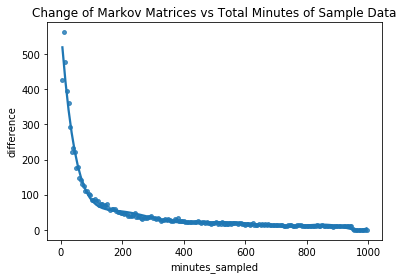

In [63]:
ax = sns.regplot(x="minutes_sampled", y="difference", data=df,
                 scatter_kws={"s": 15},
                 order=8, ci=None, truncate=True).set_title('Change of Markov Matrices vs Total Minutes of Sample Data')
ax.figure.savefig(fig_prefix + "difference_between_markov_matrices")

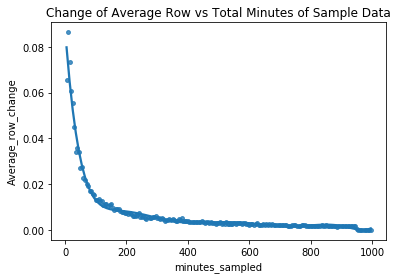

In [66]:
ax = sns.regplot(x="minutes_sampled", y="Average_row_change", data=df,
                 scatter_kws={"s": 15},
                 order=8, ci=None, truncate=True).set_title('Change of Average Row vs Total Minutes of Sample Data')
ax.figure.savefig(fig_prefix + "difference_between_markov_matrices_Average_Row")